# <h1> Data Processing</h1>

<h2>Problem Statement </h2>
<p>We want to type in our app the list of ingredients for the new recipe that we have learned. Typing on our mobile device can be easier if the app can present five options for what the next word might be. Nevertheless, to train such models for machine learning large amount of data are needed.</p></br>

<p>In this notebook, data extraction and preprocessing steps are decribed and implemented as below:</p></br>
<ol>
<li>Read Data</li>
<li>
Preprocess Data
<ol>
<li>Apply standard preprocessing</li>
<li>Apply Exact Matching</li>
<li>Replace spaces with underscore</li>
</ol>
</li>
<li>Save Data</li>
</ol>

## Data Generation

<p>Let's scrape ingredients from https://www.allrecipes.com/recipe/231392/whole-grain-banana-pancakes/.</p>

In [2]:
#imports for web scraping
import requests
from bs4 import BeautifulSoup

url = 'https://www.allrecipes.com/recipe/231392/whole-grain-banana-pancakes/'

#Make an http call
page = requests.get(url).text
#Tell python it is HTML content
soup = BeautifulSoup(page, 'lxml')

#Identify the element containing the list of ingredients 
ul = soup.find('ul', class_="ingredients-section")

#Get all ingredients in the recipe
ingredients_list = [li.text for li in ul.findAll('li')]
ingredients_list = [l.strip() for l in ingredients_list]

In [3]:
ingredients_list

['¾ cup whole wheat flour',
 '¼ cup almond meal',
 '¼ cup old-fashioned oats',
 '2 teaspoons baking powder',
 '¼ teaspoon salt',
 '1  egg, beaten',
 '1 cup milk',
 '1  ripe banana, mashed',
 '1 tablespoon canola oil']

<h3>Imports</h3>

In [19]:
#!pip install tqdm
!pip install wordcloud

    100% |████████████████████████████████| 225kB 3.2MB/s ta 0:00:01
  Running setup.py install for wordcloud ... done


In [8]:
import logging
logging.basicConfig(level=logging.INFO)

#Load the dataset given in json format
import json
#Use pandas to convert it to pandas DataFrame 
import pandas as pd 
from pandas.io.json import json_normalize

#Data Cleaning
import re
import string

#Data Saving
import pickle
from tqdm import tqdm 

## Recipe1M+

<p>Recipe1M+ dataset is the biggest publicly available recipe dataset [1]. The information each recipe contains is separated in two JavaScript Object Notation (JSON) files.</p>

In [9]:
file_path = '100ksample.json'
with open(file_path, 'r', encoding='iso-8859-1') as data_file:
  try:
    json_data = data_file.read().strip()
  except Exception as e:
    print("Could not read file {}".format(filename))
  if not json_data[0] == '[':
    json_data = '['+json_data
  if not json_data[-1] == ']':
    if json_data[-1] == ',':
      json_data = json_data[:-1]+']'
    else:
      json_data = json_data+']'
  all_data = json.loads(json_data)
  print(type(all_data))

<class 'list'>


In [10]:
recipes_df = json_normalize(all_data)
recipes_df.head(5)

/Users/aulonashabani/.virtualenv/Netlight/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """Entry point for launching an IPython kernel.


ingredients  \
0  [{'text': '6 ounces penne'}, {'text': '2 cups ...   
1  [{'text': '1 c. elbow macaroni'}, {'text': '1 ...   
2  [{'text': '8 tomatoes, quartered'}, {'text': '...   
3  [{'text': '2 12 cups milk'}, {'text': '1 12 cu...   
4  [{'text': '1 (3 ounce) package watermelon gela...   

                                                 url partition  \
0  http://www.epicurious.com/recipes/food/views/-...     train   
1  http://cookeatshare.com/recipes/dilly-macaroni...     train   
2  http://www.foodnetwork.com/recipes/gazpacho1.html     train   
3  http://www.food.com/recipe/crunchy-onion-potat...      test   
4  http://www.food.com/recipe/cool-n-easy-creamy-...     train   

                                title          id  \
0          Worlds Best Mac and Cheese  000018c8a5   
1         Dilly Macaroni Salad Recipe  000033e39b   
2                            Gazpacho  000035f7ed   
3           Crunchy Onion Potato Bake  00003a70b1   
4  Cool 'n Easy Creamy Watermelon Pie  00004320bb   

                                        instructions  
0  [{'text': 'Preheat the oven to 350 F. Butter o...  
1  [{'text': 'Cook macaroni according to package ...  
2  [{'text': 'Add the tomatoes to a food processo...  
3  [{'text': 'Preheat oven to 350 degrees Fahrenh...  
4  [{'text': 'Dissolve Jello in boiling water.'},...

In [11]:
recipes_df.tail()

ingredients  \
99994  [{'text': '14 cup butter'}, {'text': '14 cup s...   
99995  [{'text': '1 crispy chicken homade or store br...   
99996  [{'text': '3 pounds hanger steak, cut into 2-i...   
99997  [{'text': '1 tbsp unsalted butter'}, {'text': ...   
99998  [{'text': '1 3/4 c. hazelnuts'}, {'text': '2 t...   

                                                     url partition  \
99994  http://www.food.com/recipe/hersheys-disappeari...       val   
99995  https://cookpad.com/us/recipes/358624-crispy-c...     train   
99996  http://www.foodnetwork.com/recipes/guy-fieri/d...     train   
99997  https://cookpad.com/us/recipes/364329-blondies...     train   
99998  http://www.chowhound.com/recipes/chocolate-mou...      test   

                                                   title          id  \
99994                        Hershey's Disappearing Cake  18c5efac25   
99995                               Crispy chicken salad  18c5ff5968   
99996                                   Double Jack Stew  18c6060eb7   
99997  Blondie's Dad's Take Me Out To The Ballgame Mi...  18c606f28e   
99998               Chocolate Mousse Cake Recipe chowser  18c6112dda   

                                            instructions  
99994  [{'text': 'Generously grease and flour 2-9 inc...  
99995  [{'text': 'Cut all ingriedients to personal si...  
99996  [{'text': 'Pair this hearty stew with a dry Ir...  
99997  [{'text': 'Position an oven rack in the center...  
99998  [{'text': 'Butter 9" springform pan.'}, {'text...

In [12]:
recipes_df.columns = ['ingredients', 'url', 'partition', 'title', 'id', 'instructions']
recipes_df.columns

Index(['ingredients', 'url', 'partition', 'title', 'id', 'instructions'], dtype='object')

In [13]:
#Sanity check
for dics in (recipes_df.ingredients[0]):
  for ing in dics:
    print(dics[ing])

6 ounces penne
2 cups Beechers Flagship Cheese Sauce (recipe follows)
1 ounce Cheddar, grated (1/4 cup)
1 ounce Gruyere cheese, grated (1/4 cup)
1/4 to 1/2 teaspoon chipotle chili powder (see Note)
1/4 cup (1/2 stick) unsalted butter
1/3 cup all-purpose flour
3 cups milk
14 ounces semihard cheese (page 23), grated (about 3 1/2 cups)
2 ounces semisoft cheese (page 23), grated (1/2 cup)
1/2 teaspoon kosher salt
1/4 to 1/2 teaspoon chipotle chili powder
1/8 teaspoon garlic powder
(makes about 4 cups)


## Data Preprocessing functions

In [14]:
#Input is of list format
def clean_data_1st_iter(lst):
  lst = [text.lower() for text in lst]
  lst = [re.sub('\[.*?\'\]', '', text) for text in lst]
  lst = [re.sub('[%s]' % re.escape(string.punctuation), '', text) for text in lst]
  lst = [re.sub('\w*\d\w*', '', text) for text in lst]
  lst = [re.sub('[‘’“”…]', '', text) for text in lst]
  lst = [re.sub('\n', '', text) for text in lst]
  return lst

first_data_cleanup = lambda x: clean_data_1st_iter(x)

In [15]:
def extract_exact_matches(ingredients_1mil_lst, compound_ingredients):
  pattern1 = r'\b(?:%s)\b' % '|'.join(ingredients_1mil_lst)
  ingredients_1mil_regex_obj = re.compile(pattern1)

  cleaned_ingredients = lambda x: list(filter(None, 
                                        ingredients_1mil_regex_obj.findall(x)))
  final_res = list(filter(None, 
                    [cleaned_ingredients(ing) for ing in compound_ingredients]))

  return final_res

In [16]:
def clean_data_2nd_iter(lst):
  lst = [re.sub(r'\s', '_', text) for text in lst]
  return lst

second_data_cleanup = lambda x: clean_data_2nd_iter(x)

<h3>Help functions:</h3>

In [17]:
#static function
flatten = lambda l: [item for sublist in l for item in sublist]

In [20]:
# Python program to generate WordCloud 
  
# importing all necessery modules 
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt 
import pandas as pd 

def generate_word_cloud(read_df, save_path, collocations=True): 
  # iterate through the DataFrame content 
  all_ingredients = flatten(list(read_df))
  ingredients_freq = Counter(all_ingredients)

  wordcloud = WordCloud(collocations=collocations, width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(ingredients_freq) 

  # plot the WordCloud image                        
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  plt.savefig(save_path)
  plt.show() 

## 2. Apply preprocessing steps

In [23]:
file_path = 'cleaned_ingredients.json'
ing_list = [json.loads(line) for line in open(file_path, 'r')]
len(ing_list)

1895

In [24]:
ing_list[:10]

['Alkanna tinctoria',
 'Apricot',
 'Asparagus',
 'Bamboo',
 'Banana',
 'Beef',
 'Beeswax',
 'Berry',
 'Brandy',
 'Bread']

Apply the 1st round of data cleaning to the 18k list of ingredients, for compatibility with our data

In [25]:
ing_list = clean_data_1st_iter(ing_list)
ing_list[:18]

['alkanna tinctoria',
 'apricot',
 'asparagus',
 'bamboo',
 'banana',
 'beef',
 'beeswax',
 'berry',
 'brandy',
 'bread',
 'breadfruit',
 'butter',
 'cabbage',
 'cake',
 'cassava',
 'catfish',
 'cherry',
 'chicken']

### Retrieve this format: Recipe_id     [ing1, ing2, ...]


Derive a DataFrame format, with recipes' ids as rows indices, and one column, containing list of ingredients, corresponding to each particular recipe. 

In [27]:
flatten_ingredients_with_id_df = json_normalize(data=all_data, record_path='ingredients', meta=['id', 'title'])
flatten_ingredients_with_id_df.head()

/Users/aulonashabani/.virtualenv/Netlight/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """Entry point for launching an IPython kernel.


text          id  \
0                                     6 ounces penne  000018c8a5   
1  2 cups Beechers Flagship Cheese Sauce (recipe ...  000018c8a5   
2                  1 ounce Cheddar, grated (1/4 cup)  000018c8a5   
3           1 ounce Gruyere cheese, grated (1/4 cup)  000018c8a5   
4  1/4 to 1/2 teaspoon chipotle chili powder (see...  000018c8a5   

                        title  
0  Worlds Best Mac and Cheese  
1  Worlds Best Mac and Cheese  
2  Worlds Best Mac and Cheese  
3  Worlds Best Mac and Cheese  
4  Worlds Best Mac and Cheese

In [28]:
#groupby_id
recipe_ingredients_df = flatten_ingredients_with_id_df.groupby('id').agg(lambda x: x.tolist())

recipe_ingredients_df.columns = ['recipe_ingredients', 'title']
recipe_ingredients_df.head()

recipe_ingredients  \
id                                                              
000018c8a5  [6 ounces penne, 2 cups Beechers Flagship Chee...   
000033e39b  [1 c. elbow macaroni, 1 c. cubed American chee...   
000035f7ed  [8 tomatoes, quartered, Kosher salt, 1 red oni...   
00003a70b1  [2 12 cups milk, 1 12 cups water, 14 cup butte...   
00004320bb  [1 (3 ounce) package watermelon gelatin, 14 cu...   

                                                        title  
id                                                             
000018c8a5  [Worlds Best Mac and Cheese, Worlds Best Mac a...  
000033e39b  [Dilly Macaroni Salad Recipe, Dilly Macaroni S...  
000035f7ed  [Gazpacho, Gazpacho, Gazpacho, Gazpacho, Gazpa...  
00003a70b1  [Crunchy Onion Potato Bake, Crunchy Onion Pota...  
00004320bb  [Cool 'n Easy Creamy Watermelon Pie, Cool 'n E...

In [29]:
recipe_ingredients_df.title = [title[0] for title in recipe_ingredients_df.title]

In [30]:
recipe_ingredients_df.head()

recipe_ingredients  \
id                                                              
000018c8a5  [6 ounces penne, 2 cups Beechers Flagship Chee...   
000033e39b  [1 c. elbow macaroni, 1 c. cubed American chee...   
000035f7ed  [8 tomatoes, quartered, Kosher salt, 1 red oni...   
00003a70b1  [2 12 cups milk, 1 12 cups water, 14 cup butte...   
00004320bb  [1 (3 ounce) package watermelon gelatin, 14 cu...   

                                         title  
id                                              
000018c8a5          Worlds Best Mac and Cheese  
000033e39b         Dilly Macaroni Salad Recipe  
000035f7ed                            Gazpacho  
00003a70b1           Crunchy Onion Potato Bake  
00004320bb  Cool 'n Easy Creamy Watermelon Pie

### 2.1. Apply first round of the preprocessing steps

In [31]:
cleaned_recipe_ingredients = recipe_ingredients_df.recipe_ingredients.apply(first_data_cleanup)
cleaned_recipe_ingredients_df = recipe_ingredients_df
cleaned_recipe_ingredients_df.recipe_ingredients = cleaned_recipe_ingredients

In [32]:
cleaned_recipe_ingredients_df.head()

recipe_ingredients  \
id                                                              
000018c8a5  [ ounces penne,  cups beechers flagship cheese...   
000033e39b  [ c elbow macaroni,  c cubed american cheese  ...   
000035f7ed  [ tomatoes quartered, kosher salt,  red onion ...   
00003a70b1  [  cups milk,   cups water,  cup butter, mashe...   
00004320bb  [  ounce package watermelon gelatin,  cup boil...   

                                         title  
id                                              
000018c8a5          Worlds Best Mac and Cheese  
000033e39b         Dilly Macaroni Salad Recipe  
000035f7ed                            Gazpacho  
00003a70b1           Crunchy Onion Potato Bake  
00004320bb  Cool 'n Easy Creamy Watermelon Pie

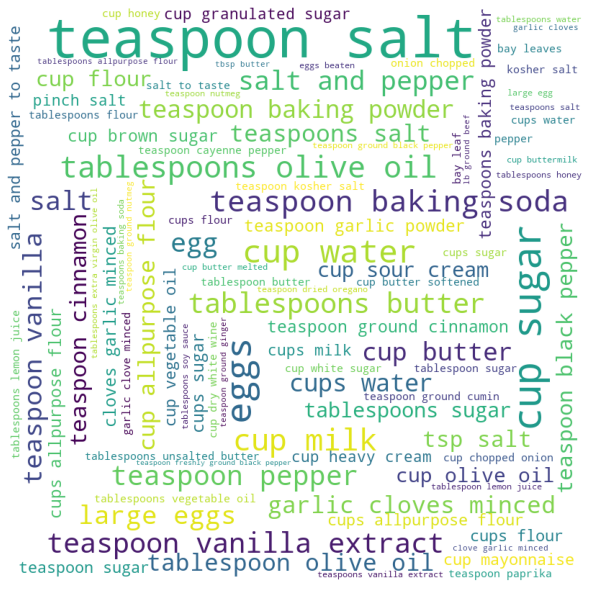

In [33]:
# do not consider bigrams
generate_word_cloud(cleaned_recipe_ingredients_df.recipe_ingredients,'round1.jpg', collocations=False)

### 2.2. Extract Exact Matches

Derive exact matches for the list of ingredients of each recipe, by firstly converting the current DataFrame to a dictionary.

In [34]:
recipes_ingredients_dict = cleaned_recipe_ingredients_df.to_dict()

In [35]:
recipes_ingredients_dict

{'recipe_ingredients': {'000018c8a5': [' ounces penne',
   ' cups beechers flagship cheese sauce recipe follows',
   ' ounce cheddar grated  cup',
   ' ounce gruyere cheese grated  cup',
   ' to  teaspoon chipotle chili powder see note',
   ' cup  stick unsalted butter',
   ' cup allpurpose flour',
   ' cups milk',
   ' ounces semihard cheese page  grated about   cups',
   ' ounces semisoft cheese page  grated  cup',
   ' teaspoon kosher salt',
   ' to  teaspoon chipotle chili powder',
   ' teaspoon garlic powder',
   'makes about  cups'],
  '000033e39b': [' c elbow macaroni',
   ' c cubed american cheese  ounce',
   ' c sliced celery',
   ' c minced green pepper',
   ' tbsp minced pimento',
   ' c mayonnaise or possibly salad dressing',
   ' tbsp vinegar',
   ' teaspoon salt',
   ' teaspoon dry dill weed'],
  '000035f7ed': [' tomatoes quartered',
   'kosher salt',
   ' red onion cut into small dice',
   ' green bell pepper cut into small dice',
   ' red bell pepper cut into small dice

In [36]:
reduced_recipes_ingredients_dict = recipes_ingredients_dict['recipe_ingredients']

for recipe_id in tqdm(reduced_recipes_ingredients_dict):
  recipe_ings = reduced_recipes_ingredients_dict[recipe_id]
  cleaned_recipe_ing_df = extract_exact_matches(ing_list, recipe_ings)
  cleaned_recipe_ing_df = flatten(cleaned_recipe_ing_df)
  reduced_recipes_ingredients_dict[recipe_id] = cleaned_recipe_ing_df


100%|██████████| 99999/99999 [01:00<00:00, 1651.24it/s]


In [37]:
#Sanity check - do we still have the 100k sample?
len(reduced_recipes_ingredients_dict)

99999

In [38]:
#saving previous data format
recipes_ingredients_dict['recipe_ingredients'] = reduced_recipes_ingredients_dict

In [39]:
type(recipes_ingredients_dict)

dict

In [40]:
#convert back to data frame
recipe_ingredients_df = pd.DataFrame(recipes_ingredients_dict)

In [41]:
#Now, cleaned ingredient, after exact matching
recipe_ingredients_df.head()

recipe_ingredients  \
000018c8a5  [penne, cheese, sauce, cheese, chili powder, b...   
000033e39b  [macaroni, cheese, celery, green, pepper, pime...   
000035f7ed  [tomatoes, salt, red onion, green, bell pepper...   
00003a70b1  [milk, water, butter, mashed potatoes, corn, c...   
00004320bb  [watermelon, gelatin, boiling water, cool whip...   

                                         title  
000018c8a5          Worlds Best Mac and Cheese  
000033e39b         Dilly Macaroni Salad Recipe  
000035f7ed                            Gazpacho  
00003a70b1           Crunchy Onion Potato Bake  
00004320bb  Cool 'n Easy Creamy Watermelon Pie

In [42]:
recipe_ingredients_df.tail()

recipe_ingredients  \
18c5efac25  [butter, shortening, sugar, vanilla, eggs, flo...   
18c5ff5968  [chicken, lettuce, tomatoes, cucumber, cheese,...   
18c6060eb7  [steak, whiskey, garlic, salt, black pepper, o...   
18c606f28e  [butter, sugar, cayenne pepper, paprika, coria...   
18c6112dda  [hazelnuts, butter, chocolate, cream, eggs, va...   

                                                        title  
18c5efac25                        Hershey's Disappearing Cake  
18c5ff5968                               Crispy chicken salad  
18c6060eb7                                   Double Jack Stew  
18c606f28e  Blondie's Dad's Take Me Out To The Ballgame Mi...  
18c6112dda               Chocolate Mousse Cake Recipe chowser

### 2.3. Apply second round of preprocessing, by replacing space with underscore

In [43]:
cleaned_recipe_ingredients = recipe_ingredients_df.recipe_ingredients.apply(second_data_cleanup)
recipe_ingredients_df.recipe_ingredients = cleaned_recipe_ingredients

In [44]:
recipe_ingredients_df.head()

recipe_ingredients  \
000018c8a5  [penne, cheese, sauce, cheese, chili_powder, b...   
000033e39b  [macaroni, cheese, celery, green, pepper, pime...   
000035f7ed  [tomatoes, salt, red_onion, green, bell_pepper...   
00003a70b1  [milk, water, butter, mashed_potatoes, corn, c...   
00004320bb  [watermelon, gelatin, boiling_water, cool_whip...   

                                         title  
000018c8a5          Worlds Best Mac and Cheese  
000033e39b         Dilly Macaroni Salad Recipe  
000035f7ed                            Gazpacho  
00003a70b1           Crunchy Onion Potato Bake  
00004320bb  Cool 'n Easy Creamy Watermelon Pie

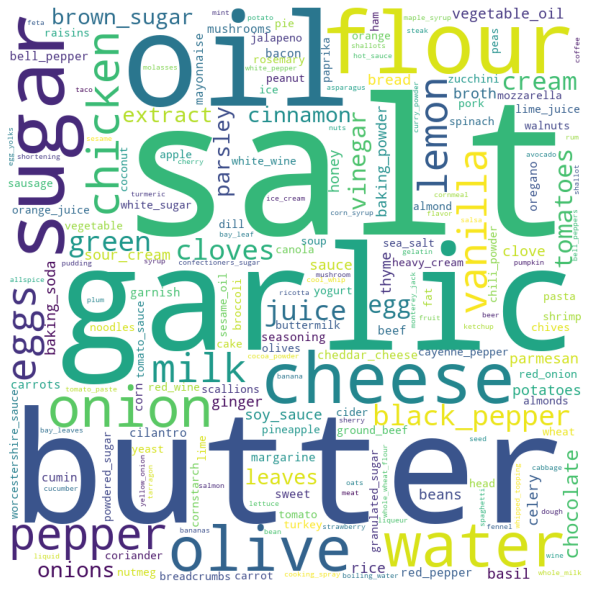

In [45]:
generate_word_cloud(recipe_ingredients_df.recipe_ingredients, 'test.png')

## Save the preprocessed Data

In [47]:
pickled_recipe100k = 'processed_ingridients.pkl'
with open(pickled_recipe100k, 'wb') as pkl_recipe100k:
    pickle.dump(recipe_ingredients_df, pkl_recipe100k)

In [48]:
recipe_ingredients = pd.read_pickle('processed_ingridients.pkl')
recipe_ingredients_df = pd.DataFrame(recipe_ingredients)
recipe_ingredients_df.head()

recipe_ingredients  \
000018c8a5  [penne, cheese, sauce, cheese, chili_powder, b...   
000033e39b  [macaroni, cheese, celery, green, pepper, pime...   
000035f7ed  [tomatoes, salt, red_onion, green, bell_pepper...   
00003a70b1  [milk, water, butter, mashed_potatoes, corn, c...   
00004320bb  [watermelon, gelatin, boiling_water, cool_whip...   

                                         title  
000018c8a5          Worlds Best Mac and Cheese  
000033e39b         Dilly Macaroni Salad Recipe  
000035f7ed                            Gazpacho  
00003a70b1           Crunchy Onion Potato Bake  
00004320bb  Cool 'n Easy Creamy Watermelon Pie